In [1]:
from qdrant_client import QdrantClient
from qdrant_client.http import models
import timeit
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import uuid
from scipy.sparse import csr_matrix
import timeit
from dateutil import parser



try:
  import os
  import numpy as np
  import pandas as pd
  import sys
  import json
  from ast import literal_eval
  from tqdm import tqdm
  import datetime
  import threading

except Exception as e:
  print(f"error: {e}")

import timeit
import statistics
import matplotlib.pyplot as plt


import docker

In [2]:
client = docker.from_env()
containers = client.containers.list()
for container in containers:
    print(f"ID del contenedor: {container.id}, Nombre: {container.name}")

ID del contenedor: 0bacfaff14f9ad6a4db7ab7eb9a38dc36fe342f630dfa57f2340c817cbd2e41b, Nombre: web


In [3]:
def vectorize_embed(data: pd.DataFrame, datacol: str = 'TEXTO', dim=64):
    vectorizer = TfidfVectorizer()
    emb = vectorizer.fit_transform(data[datacol])
    svd = TruncatedSVD(dim)
    embedding = svd.fit_transform(emb)
    return vectorizer, svd, embedding

def gen_dataset(dataurl: str = 'textos.csv', datacol: str = 'TEXTO', dim=64):
    data = pd.read_csv(dataurl)
    vectorizer, svd, embedding = vectorize_embed(data, datacol, dim)
    data = data.drop(columns=datacol).reset_index(drop=True)
    data['embedding'] = [vec.tolist() for vec in embedding]

    # Crear una lista con los datos vectorizados y los metadatos
    data_list = []
    for index, row in data.iterrows():
        data_list.append((row['AUTOR'], row['TITULO'], np.array(row['embedding'])))

    return vectorizer, svd, data_list
def getVectorSps(vector):
  vector_sparse = csr_matrix(vector)
  indices = vector_sparse.indices
  values = vector_sparse.data
  return {index: value for index, value in zip(indices, values)}

In [4]:
class QdrantBdd:
  def __init__(self):
    self.client = QdrantClient(":memory:")
    self.collection = None
    self.collection_name = None
    self.point_id = 1
    self.report = {}

  def create_collection(self, collection_name):
    self.client.recreate_collection(
        collection_name = collection_name,
         vectors_config={},
         sparse_vectors_config={
         "text": models.SparseVectorParams(
         index=models.SparseIndexParams(
         on_disk=False,
         )
         )
         },

      )
    self.collection_name = collection_name
    pass

  def addVectors(self, data):
    tim1 = timeit.default_timer()
    for dat in data:
      sparse_dict = getVectorSps(dat[2])
      indices = list(sparse_dict.keys())
      values = list(sparse_dict.values())
      self.client.upsert(
      collection_name=self.collection_name,
      points=[
      models.PointStruct(
      id=self.point_id,
      payload={}, # Add any additional payload if necessary
      vector={
      "text": models.SparseVector(
      indices=indices, values=values)
      },
      )
      ],
      )
    tim2 = timeit.default_timer()
    self.report['Bt'] = tim2-tim1
    pass

  def query(self, text):
    vector = svd.transform(vectorizer.transform([text]))[0].tolist()
    indices, values = [], []
    for ind,value in enumerate(vector):
      indices.append(ind)
      values.append(value)
    result = self.client.search(
      collection_name=self.collection_name,
      query_vector=models.NamedSparseVector(
      name="text",
      vector=models.SparseVector(
      indices=indices,
      values=values,
      ),
      ),
      with_vectors=True,
    )
    return result


  def getqps(self, query_string, num_queries):
    start_time = timeit.default_timer()
    for _ in range(num_queries):
      res = self.query(query_string)
    end_time = timeit.default_timer()

    qps = num_queries / (end_time - start_time)
    return qps

  def indextime(self):
    return self.report['Bt']

In [5]:
data = pd.read_csv("textos.csv")
vectorizer, svd, data = gen_dataset("textos.csv")

In [6]:
def profiler(container):
    cpu_max = 0
    container_history = [] # create an empty list to store the stats
    std_array = np.zeros([50])
    std_index = 0
    for stats in container.stats(stream=True, decode=True): # iterate over the stats generator
        container_history.append(stats)
        print(stats)
        cpu_value = stats["cpu_stats"]["cpu_usage"]["total_usage"]
        memory_value = stats["memory_stats"]["usage"]
        std_array[std_index] = cpu_value
        std_index = std_index + 1
        if std_index>=50:
            std_index = 0
        #print(std_array.std())
        if cpu_value > cpu_max:
            cpu_max = cpu_value
        if std_array.std() < 0.1*cpu_max:
            break
    return container_history

def cpu_usage_plot(stats_history, caption, return_percentages = False):
    cpu_total_usage = []

    wait_index = 0
    for stats in stats_history:
        if wait_index > 1:
            UsageDelta = stats['cpu_stats']['cpu_usage']['total_usage'] - stats['precpu_stats']['cpu_usage']['total_usage']
            SystemDelta = stats['cpu_stats']['system_cpu_usage'] - stats["precpu_stats"]["system_cpu_usage"]
            len_cpu = len(stats['cpu_stats']['cpu_usage']['percpu_usage'])
            percentage = (UsageDelta / SystemDelta) * len_cpu * 100
            cpu_total_usage.append(percentage)
        wait_index = wait_index + 1

    time = [stats["read"] for stats in stats_history]
    time = [parser.parse(t) for t in time]
    time_diff = [(t - time[0]).total_seconds() for t in time]
    delta = len(time_diff)-len(cpu_total_usage)
    plt.plot(time_diff[delta:], cpu_total_usage)
    plt.xlabel("Time [s]")
    plt.ylabel("CPU Percent Usage")
    plt.title("CPU usage for " + caption)
    plt.grid()
    plt.show()
    if return_percentages:
        return cpu_total_usage
    
def memory_usage_plot(stats_history, caption, return_memory = False):
    memory_total_usage = []

    wait_index = 0
    for stats in stats_history:
        if wait_index > 1:
            memory = stats["memory_stats"]["usage"]/(1024**2)
            memory_total_usage.append(memory)
        wait_index = wait_index + 1

    time = [stats["read"] for stats in stats_history]
    time = [parser.parse(t) for t in time]
    time_diff = [(t - time[0]).total_seconds() for t in time]
    delta = len(time_diff)-len(memory_total_usage)
    plt.plot(time_diff[delta:], memory_total_usage)
    plt.xlabel("Time [s]")
    plt.ylabel("Memory Usage (MB)")
    plt.title("Memory usage for " + caption)
    plt.grid()
    plt.show()
    if return_memory:
        return memory_total_usage

def io_usage_plot(stats_history, caption, return_io = False):
    io_rx_total_usage = []
    io_tx_total_usage = []

    wait_index = 0
    for stats in stats_history:
        if wait_index > 1:
            rx = stats["networks"]["eth0"]["rx_bytes"]/(1024**2)
            tx = stats["networks"]["eth0"]["tx_bytes"]/(1024**2)
            io_rx_total_usage.append(rx)
            io_tx_total_usage.append(tx)
        wait_index = wait_index + 1

    time = [stats["read"] for stats in stats_history]
    time = [parser.parse(t) for t in time]
    time_diff = [(t - time[0]).total_seconds() for t in time]
    delta = len(time_diff)-len(io_tx_total_usage)
    plt.plot(time_diff[delta:], io_rx_total_usage, label="RX")
    plt.plot(time_diff[delta:], io_tx_total_usage, label = "TX")
    plt.legend(loc="upper left")
    plt.xlabel("Time [s]")
    plt.ylabel("Network Usage")
    plt.title("Network for " + caption)
    plt.grid()
    plt.legend()
    plt.show()
    if return_io:
        return io_total_usage

In [15]:
qd01_container = client.containers.get("e37b130b4226114a91a1b2cf61376dd1962298413c4f3fafa5db504878d1bde7")
start_time = timeit.default_timer()
qd01_container.start()
qd01_stats_history = profiler(qd01_container)
print("-> See stats")

qd01_docker_start_time = timeit.default_timer() - start_time

print(f"It took {qd01_docker_start_time} to run QD01.")


{'read': '2024-01-09T04:33:30.104862323Z', 'preread': '0001-01-01T00:00:00Z', 'pids_stats': {'current': 13}, 'blkio_stats': {'io_service_bytes_recursive': [], 'io_serviced_recursive': [], 'io_queue_recursive': [], 'io_service_time_recursive': [], 'io_wait_time_recursive': [], 'io_merged_recursive': [], 'io_time_recursive': [], 'sectors_recursive': []}, 'num_procs': 0, 'storage_stats': {}, 'cpu_stats': {'cpu_usage': {'total_usage': 74413000, 'percpu_usage': [11419600, 1251900, 8263700, 3430700, 3142300, 2245600, 13887300, 2220600, 15592400, 1747800, 10367700, 843400], 'usage_in_kernelmode': 70000000, 'usage_in_usermode': 0}, 'system_cpu_usage': 153443530000000, 'online_cpus': 12, 'throttling_data': {'periods': 0, 'throttled_periods': 0, 'throttled_time': 0}}, 'precpu_stats': {'cpu_usage': {'total_usage': 0, 'usage_in_kernelmode': 0, 'usage_in_usermode': 0}, 'throttling_data': {'periods': 0, 'throttled_periods': 0, 'throttled_time': 0}}, 'memory_stats': {'usage': 10485760, 'max_usage': 1

In [16]:
stats = client.containers.get('web').stats(stream=False)


In [23]:
stats["memory_stats"]['usage']

10473472

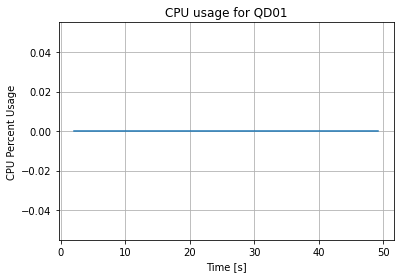

In [18]:
cpu_usage_plot(qd01_stats_history, 'QD01', False)
     

In [7]:
qc = QdrantBdd()
qc.create_collection('example_collection')
qc.addVectors(data)

print(qc.getqps('bullita', 5))
print(qc.indextime())

32.58925545283502
0.03517729999999375


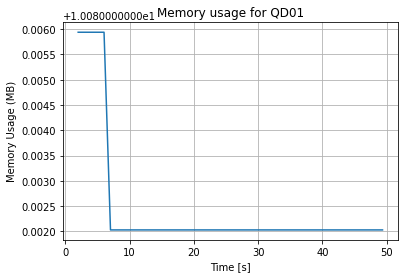

In [36]:
memory_usage_plot(qd01_stats_history, "QD01")

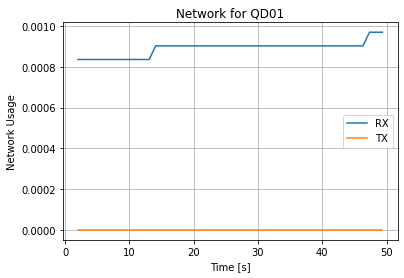

In [37]:
io_usage_plot(qd01_stats_history, "QD01")